### Import Neccessary Libraries

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
from torchinfo import summary

import matplotlib.pyplot as plt
import pandas as pd
from torchmetrics import Accuracy, ConfusionMatrix
from timeit import default_timer as timer

from tqdm.auto import tqdm
import random
from mlxtend.plotting import plot_confusion_matrix

In [2]:
print(
    f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.4.1+cu124
torchvision version: 0.19.1+cu124


##### Device Agnostic Code

In [4]:
device = 'cpu'

The smaller model_0 and model_1 runs faster on CPU

In [5]:
device

'cpu'

### Downloading our Dataset

In [6]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",  # where to download data to?
    train=True,  # get training data
    download=True,  # download data if it doesn't exist on disk
    transform=ToTensor(),  # images come as PIL format, we want to turn into Torch tensors
    target_transform=None  # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,  # get test data
    download=True,
    transform=ToTensor()
)

### EDA

In [7]:
# See first training sample
image, label = train_data[0]
image, label, image.shape

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

Image is a grayscale image because of the shape [1, 28, 28]: [color_channels=1, height=28, width=28] 


In [5]:
len(train_data.data), len(train_data.targets), len(
    test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [8]:
# See classes
class_names = train_data.classes
num_classes = len(class_names)
class_names, num_classes

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

#### Visualizing our Data

Image shape: torch.Size([1, 28, 28])


torch.Size([28, 28])

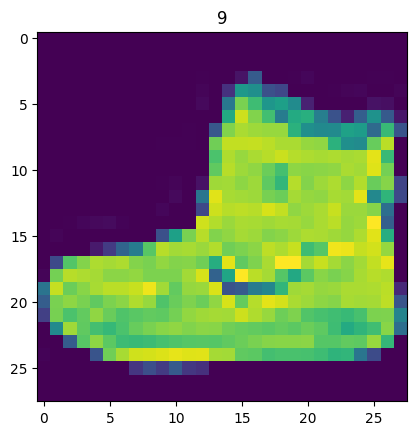

In [14]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
# image shape is [1, 28, 28] (colour channels, height, width)
plt.imshow(image.squeeze())
plt.title(label)

We can turn the image into grayscale using the `cmap` parameter of `plt.imshow()`.

Text(0.5, 1.0, 'Ankle boot')

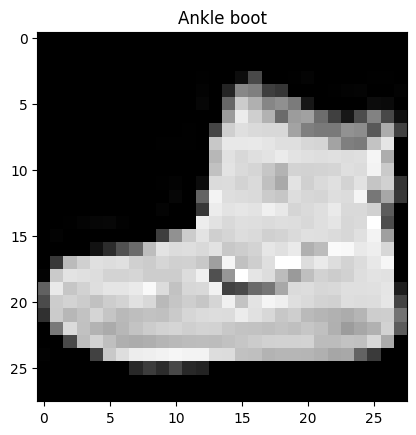

In [15]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

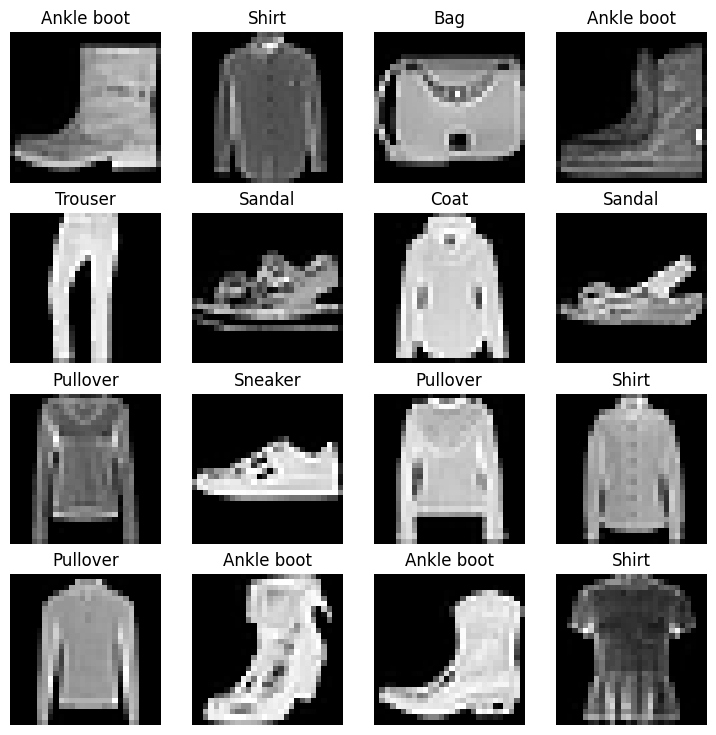

In [16]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

##### The Batch Size is an Hyper Parameter   
Splitting our data into mini batches also help our model improve during training, because the gradient descent is calculated once per batch and not once per epoch of a single batch of the whole dataset

In [9]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(
    f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(
    f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000022DA42A6AD0>, <torch.utils.data.dataloader.DataLoader object at 0x0000022DC3942B00>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [24]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape, len(train_features_batch)

(torch.Size([32, 1, 28, 28]), torch.Size([32]), 32)

Data stays the same after dataloader processs

Image size: torch.Size([1, 28, 28])
Label: 9, label size: torch.Size([])


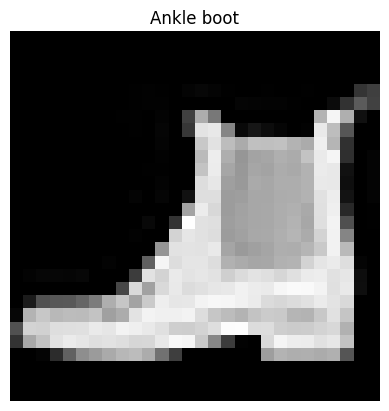

In [25]:
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off")
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

### Creating The Model

nn.flatten() layer compresses the dimensions of a tensor into a single vector

In [26]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)

print(f"shape before flattening: {x.shape} -> [C,H,W]")
print(f"shape after flattening: {output.shape} -> [C, H*W]")

shape before flattening: torch.Size([1, 28, 28]) -> [C,H,W]
shape after flattening: torch.Size([1, 784]) -> [C, H*W]


In [10]:
class FashionMnistModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [11]:
torch.manual_seed(42)

model_0 = FashionMnistModelV0(784, 10, num_classes).to('cpu')
model_0

FashionMnistModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [12]:
accuracy_fn = Accuracy(task='multiclass', num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [96]:
i=0
for X,y in train_dataloader:
    if i < 2:
        print( X.shape, y.shape)
        i += 1
    else:
        break

torch.Size([32, 1, 28, 28]) torch.Size([32])
torch.Size([32, 1, 28, 28]) torch.Size([32])


In [97]:
i = 0
for batch, (X,y) in enumerate(train_dataloader):
    if i<2:
        print(X.shape, y.shape)
        i += 1
    else: break

torch.Size([32, 1, 28, 28]) torch.Size([32])
torch.Size([32, 1, 28, 28]) torch.Size([32])


### Training

Calculating the time it will take to train our model

In [13]:
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [14]:
torch.manual_seed(42)
train_time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    train_loss = 0

    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        y_logits = model_0(X)
        loss = loss_fn(y_logits, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
        
    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0,0
    model_0.eval()

    with torch.inference_mode():
        for X,y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%\n")

train_end = timer()
total_train_time_model_0 = print_train_time(train_time_start, train_end, device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test Acc: 0.82%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test Acc: 0.83%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test Acc: 0.83%

Train time on cpu: 29.313 seconds


### Making Predictions and getting our Model Results

In [15]:
torch.manual_seed(42)


def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y,
                               y_pred.argmax(dim=1))  # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,  # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc*100}

In [16]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
                             loss_fn=loss_fn, accuracy_fn=accuracy_fn
                             )
model_0_results

{'model_name': 'FashionMnistModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': tensor(83.4265)}

### Building a new Model with non linear layers

In [17]:
class FashionMnistModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=15),
            nn.ReLU(),
            nn.Linear(in_features=15, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [18]:
torch.manual_seed(42)
model_1 = FashionMnistModelV1(input_shape=784, hidden_units=10, output_shape=num_classes).to(device) 

In [19]:
model_1.state_dict, next(model_1.parameters()).device

(<bound method Module.state_dict of FashionMnistModelV1(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): ReLU()
     (3): Linear(in_features=10, out_features=15, bias=True)
     (4): ReLU()
     (5): Linear(in_features=15, out_features=10, bias=True)
   )
 )>,
 device(type='cpu'))

In [20]:
next(model_1.parameters()).device

device(type='cpu')

In [21]:
accuracy_fn = Accuracy(task='multiclass', num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### Train and Test custom functions

In [22]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y,
                                 y_pred.argmax(dim=1))  # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {(train_acc*100):.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y,
                                    # Go from logits -> pred labels
                                    test_pred.argmax(dim=1)
                                    )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {(test_acc*100):.2f}%\n")

In [24]:
from timeit import default_timer as timer
torch.manual_seed(42)

# Measure time
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
               model=model_1,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn
               )
    test_step(data_loader=test_dataloader,
              model=model_1,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn
              )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.42973 | Train accuracy: 84.57%
Test loss: 0.45560 | Test accuracy: 83.59%

Epoch: 1
---------
Train loss: 0.41956 | Train accuracy: 84.83%
Test loss: 0.43286 | Test accuracy: 84.53%

Epoch: 2
---------
Train loss: 0.40971 | Train accuracy: 85.25%
Test loss: 0.44162 | Test accuracy: 84.23%

Epoch: 3
---------
Train loss: 0.40360 | Train accuracy: 85.38%
Test loss: 0.43719 | Test accuracy: 84.36%

Epoch: 4
---------
Train loss: 0.39918 | Train accuracy: 85.62%
Test loss: 0.44936 | Test accuracy: 84.27%

Train time on cpu: 52.438 seconds


In [25]:
torch.manual_seed(42)

# Note: This will error due to `eval_model()` not using device agnostic code
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

{'model_name': 'FashionMnistModelV1',
 'model_loss': 0.4493582248687744,
 'model_acc': tensor(84.2652)}

Well the second model does not have muhc improvement compared to the first, infact if not for the additional linear layer, ending with the relu is not an optimal practice though///

### CONVOLUTIONAL NEURAL NETWORKS CNNs

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
device

'cuda'

In [2]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x= self.classifier(x)
        return x

In [6]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=num_classes).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=3, bias=True)
  )
)

In [9]:
summary(model_2, input_size=[1,1,28,28])

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModelV2                      [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 10, 28, 28]           100
│    └─ReLU: 2-2                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 10, 28, 28]           910
│    └─ReLU: 2-4                         [1, 10, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 10, 14, 14]           --
├─Sequential: 1-2                        [1, 10, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 10, 14, 14]           910
│    └─ReLU: 2-7                         [1, 10, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 10, 14, 14]           910
│    └─ReLU: 2-9                         [1, 10, 14, 14]           --
│    └─MaxPool2d: 2-10                   [1, 10, 7, 7]             --
├─Sequentia

In [34]:
accuracy_fn = Accuracy(task='multiclass', num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [88]:
from timeit import default_timer as timer
torch.manual_seed(42)

# Measure time
train_time_start_model_2 = timer()

# Train and test model
epochs = 301
for epoch in tqdm(range(epochs), desc="Training"):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
               model=model_2,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device
               )
    test_step(data_loader=test_dataloader,
              model=model_2,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device
              )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.30278 | Train accuracy: 89.10%
Test loss: 0.32493 | Test accuracy: 88.28%

Epoch: 1
---------
Train loss: 0.28764 | Train accuracy: 89.72%
Test loss: 0.29959 | Test accuracy: 89.03%

Epoch: 2
---------
Train loss: 0.27917 | Train accuracy: 89.88%
Test loss: 0.30593 | Test accuracy: 88.88%

Epoch: 3
---------
Train loss: 0.27012 | Train accuracy: 90.22%
Test loss: 0.30108 | Test accuracy: 88.89%

Epoch: 4
---------
Train loss: 0.26360 | Train accuracy: 90.43%
Test loss: 0.28071 | Test accuracy: 89.65%

Epoch: 5
---------
Train loss: 0.25693 | Train accuracy: 90.73%
Test loss: 0.29846 | Test accuracy: 89.08%

Epoch: 6
---------
Train loss: 0.25103 | Train accuracy: 90.85%
Test loss: 0.28686 | Test accuracy: 89.94%

Epoch: 7
---------
Train loss: 0.24796 | Train accuracy: 91.04%
Test loss: 0.28896 | Test accuracy: 89.74%

Epoch: 8
---------
Train loss: 0.24675 | Train accuracy: 90.97%
Test loss: 0.27559 | Test accuracy: 90.21%

Epoch: 9
---------
Train los

KeyboardInterrupt: 

: 

In [56]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3266417682170868,
 'model_acc': tensor(88.0391, device='cuda:0')}

In [57]:
model_2_results['model_acc'] = model_2_results['model_acc'].cpu().item()
model_0_results['model_acc'] = model_0_results['model_acc'].item()
model_1_results['model_acc'] = model_1_results['model_acc'].item()

In [47]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3266417682170868,
 'model_acc': tensor(88.0391)}

In [58]:
compare_results = pd.DataFrame(
    [model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMnistModelV0,0.476639,83.426514
1,FashionMnistModelV1,0.449358,84.265175
2,FashionMNISTModelV2,0.326642,88.039139


In [59]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMnistModelV0,0.476639,83.426514,29.312506
1,FashionMnistModelV1,0.449358,84.265175,52.438224
2,FashionMNISTModelV2,0.326642,88.039139,75.986193


Text(0, 0.5, 'model')

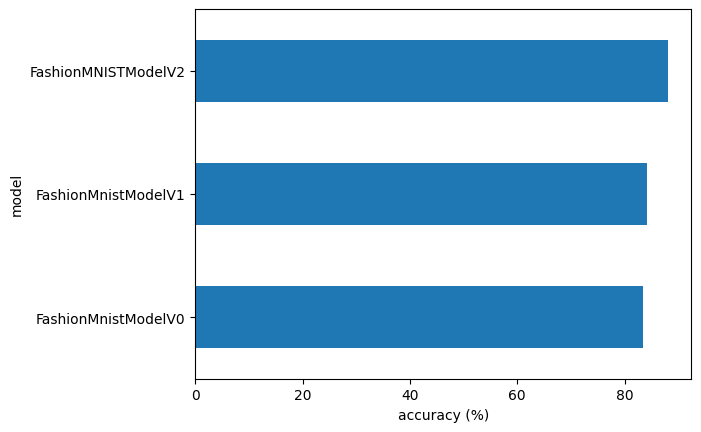

In [60]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

### Predicting with our Model

In [61]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [62]:
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(
    f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [63]:
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[8.3281e-09, 1.7621e-09, 9.4173e-09, 4.6673e-09, 1.2160e-09, 9.9998e-01,
         2.7943e-08, 2.4259e-07, 1.2471e-06, 1.4643e-05],
        [1.6898e-02, 5.3798e-01, 8.6074e-04, 7.5424e-02, 1.3462e-01, 1.6632e-04,
         2.3308e-01, 1.3355e-04, 5.1153e-04, 3.2581e-04]])

In [64]:
pred_probs.shape

torch.Size([9, 10])

In [65]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [66]:
torch.Tensor(test_labels), pred_classes

(tensor([5., 1., 7., 4., 3., 0., 4., 7., 1.]),
 tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

In [67]:
torch.eq(torch.Tensor(test_labels), pred_classes)

tensor([True, True, True, True, True, True, True, True, True])

### Plot Predictions

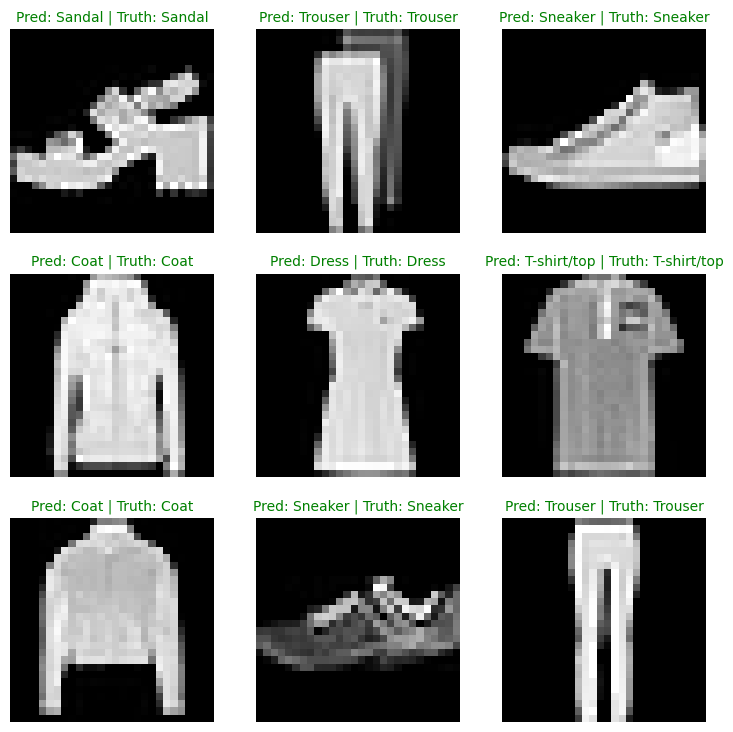

In [37]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False)

### Plotting Confusion Matrix

In [68]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc="Making Predictions"):
        X, y = X.to(device), y.to(device)
        y_logits = model_2(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())

    y_pred_tensor = torch.cat(y_preds)

Making Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [73]:
confmat = ConfusionMatrix(task='multiclass', num_classes=num_classes).to('cpu')

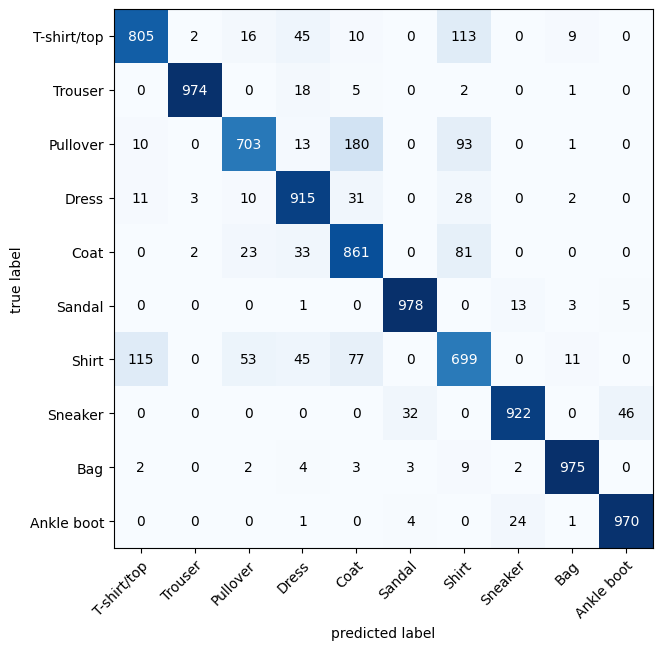

In [74]:
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(10,7)
)